In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, plot_confusion_matrix, classification_report, precision_recall_curve
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline

In [2]:
data20 = pd.read_csv('Jan_2020_ontime.csv')
data20.drop(['Unnamed: 21'], axis=1, inplace=True)
data20.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST_AIRPORT_SEQ_ID,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE
0,1,3,EV,20366,EV,N48901,4397,13930,1393007,ORD,...,1197705,GRB,1003.0,0.0,1000-1059,1117.0,0.0,0.0,0.0,174.0
1,1,3,EV,20366,EV,N16976,4401,15370,1537002,TUL,...,1393007,ORD,1027.0,0.0,1000-1059,1216.0,0.0,0.0,0.0,585.0
2,1,3,EV,20366,EV,N12167,4404,11618,1161802,EWR,...,1541205,TYS,1848.0,0.0,1800-1859,2120.0,0.0,0.0,0.0,631.0
3,1,3,EV,20366,EV,N14902,4405,10781,1078105,BTR,...,1226603,IAH,1846.0,0.0,1800-1859,2004.0,0.0,0.0,0.0,253.0
4,1,3,EV,20366,EV,N606UX,4407,14524,1452401,RIC,...,1226603,IAH,1038.0,0.0,1000-1059,1330.0,0.0,0.0,0.0,1157.0


In [3]:
data19 = pd.read_csv('Jan_2019_ontime.csv')
data19.drop(['Unnamed: 21'], axis=1, inplace=True)
#data19.head()

In [4]:
#We concatenate the two January dataset from 2019 and 2020 
data = pd.concat([data19, data20])

In [5]:
data.shape

(1191331, 21)

In [6]:
# A closer look at the dataset
data.describe()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_AIRLINE_ID,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEP_TIME,DEP_DEL15,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE
count,1.191331e+06,1.191331e+06,1.191331e+06,1.191331e+06,1.191331e+06,1.191331e+06,1.191331e+06,1.191331e+06,1.168315e+06,1.168277e+06,1.167195e+06,1.165231e+06,1.191331e+06,1.191331e+06,1.191331e+06
mean,1.598775e+01,3.896858e+00,1.998878e+04,2.580946e+03,1.265852e+04,1.265856e+06,1.265831e+04,1.265835e+06,1.331729e+03,1.547672e-01,1.481052e+03,1.609183e-01,1.985510e-02,2.053166e-03,7.978853e+02
std,8.989395e+00,1.916886e+00,3.767608e+02,1.822637e+03,1.521957e+03,1.521955e+05,1.521858e+03,1.521856e+05,4.962741e+02,3.616828e-01,5.243978e+02,3.674557e-01,1.395023e-01,4.526535e-02,5.886157e+02
min,1.000000e+00,1.000000e+00,1.939300e+04,1.000000e+00,1.013500e+04,1.013505e+06,1.013500e+04,1.013505e+06,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.100000e+01
25%,8.000000e+00,2.000000e+00,1.979000e+04,1.027000e+03,1.129200e+04,1.129202e+06,1.129200e+04,1.129202e+06,9.200000e+02,0.000000e+00,1.101000e+03,0.000000e+00,0.000000e+00,0.000000e+00,3.660000e+02
50%,1.600000e+01,4.000000e+00,1.997700e+04,2.142000e+03,1.288900e+04,1.288903e+06,1.288900e+04,1.288903e+06,1.327000e+03,0.000000e+00,1.515000e+03,0.000000e+00,0.000000e+00,0.000000e+00,6.400000e+02
75%,2.400000e+01,5.000000e+00,2.036800e+04,4.009000e+03,1.402700e+04,1.402702e+06,1.402700e+04,1.402702e+06,1.739000e+03,0.000000e+00,1.919000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.037000e+03
max,3.100000e+01,7.000000e+00,2.045200e+04,7.439000e+03,1.686900e+04,1.686901e+06,1.686900e+04,1.686901e+06,2.400000e+03,1.000000e+00,2.400000e+03,1.000000e+00,1.000000e+00,1.000000e+00,5.095000e+03


In [8]:
data.dtypes

DAY_OF_MONTH               int64
DAY_OF_WEEK                int64
OP_UNIQUE_CARRIER         object
OP_CARRIER_AIRLINE_ID      int64
OP_CARRIER                object
TAIL_NUM                  object
OP_CARRIER_FL_NUM          int64
ORIGIN_AIRPORT_ID          int64
ORIGIN_AIRPORT_SEQ_ID      int64
ORIGIN                    object
DEST_AIRPORT_ID            int64
DEST_AIRPORT_SEQ_ID        int64
DEST                      object
DEP_TIME                 float64
DEP_DEL15                float64
DEP_TIME_BLK              object
ARR_TIME                 float64
ARR_DEL15                float64
CANCELLED                float64
DIVERTED                 float64
DISTANCE                 float64
dtype: object

In [9]:
#Test if any of the features are duplicates
for feature1 in data.columns.values:
    for feature2 in data.columns.values:
        if feature1 == feature2:
            pass
        elif np.array_equal(data[feature1], data[feature2]):
            print(f'{feature1} and {feature2} are equal')
        else:
            pass

OP_UNIQUE_CARRIER and OP_CARRIER are equal
OP_CARRIER and OP_UNIQUE_CARRIER are equal


In [10]:
data['TAIL_NUM'].unique

<bound method Series.unique of 0         N8688C
1         N348PQ
2         N8896A
3         N8886A
4         N8974C
           ...  
607341    N331CA
607342    N295PQ
607343    N294PQ
607344    N228PQ
607345    N228PQ
Name: TAIL_NUM, Length: 1191331, dtype: object>

In [11]:
#We remove the "DEP_TIME" column because it basicly is a copy of "DEP_TIME_BLK" and we will drop OP_UNIQUE_CARRIER as it is a duplicate
#We will also drop TAIL_NUM as it has a lot of unique values and thus doesn't add any info to this dataset. 
data.drop(['DEP_TIME', 'OP_UNIQUE_CARRIER', 'TAIL_NUM'], axis=1, inplace=True)

#### TEST FOR CORRELATION

In [12]:
corr_matrix = data.corr(method ='pearson') #Test for correlation of features
corr_matrix

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_AIRLINE_ID,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEP_DEL15,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE
DAY_OF_MONTH,1.000000,-0.042553,-0.001265,-0.015823,-0.004971,-0.004971,-0.004963,-0.004963,-0.013177,0.006048,-0.005327,0.063046,0.000522,-0.020558
DAY_OF_WEEK,-0.042553,1.000000,0.007998,0.059044,0.005538,0.005538,0.005226,0.005226,0.022601,0.001044,0.024707,0.008820,0.001541,0.019302
OP_CARRIER_AIRLINE_ID,-0.001265,0.007998,1.000000,0.437421,-0.047495,-0.047495,-0.047675,-0.047675,0.035887,-0.015241,0.070229,0.017882,0.011691,-0.127043
OP_CARRIER_FL_NUM,-0.015823,0.059044,0.437421,1.000000,-0.054657,-0.054657,-0.059944,-0.059945,0.024047,0.007673,0.033355,0.034782,0.007428,-0.347685
ORIGIN_AIRPORT_ID,-0.004971,0.005538,-0.047495,-0.054657,1.000000,1.000000,0.017462,0.017463,0.002847,-0.004194,0.007959,0.011872,-0.001090,0.089662
ORIGIN_AIRPORT_SEQ_ID,-0.004971,0.005538,-0.047495,-0.054657,1.000000,1.000000,0.017463,0.017463,0.002847,-0.004194,0.007959,0.011872,-0.001090,0.089662
DEST_AIRPORT_ID,-0.004963,0.005226,-0.047675,-0.059944,0.017462,0.017463,1.000000,1.000000,0.009664,0.023973,0.010728,0.011055,0.003175,0.089691
DEST_AIRPORT_SEQ_ID,-0.004963,0.005226,-0.047675,-0.059945,0.017463,0.017463,1.000000,1.000000,0.009664,0.023973,0.010728,0.011055,0.003175,0.089691
DEP_DEL15,-0.013177,0.022601,0.035887,0.024047,0.002847,0.002847,0.009664,0.009664,1.000000,0.080924,0.716551,0.019339,0.020837,0.012579
ARR_TIME,0.006048,0.001044,-0.015241,0.007673,-0.004194,-0.004194,0.023973,0.023973,0.080924,1.000000,0.055586,NaN,-0.004465,0.012479


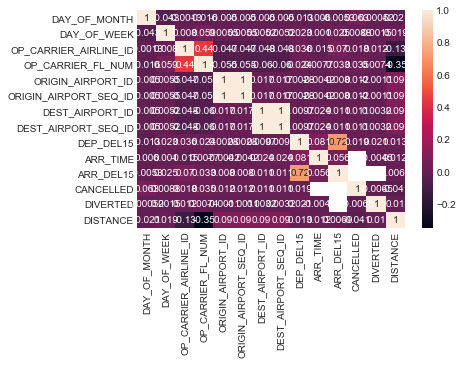

In [13]:
sn.heatmap(corr_matrix, annot=True)
plt.show()

In [14]:
# As we can see by the white squares (and "1" value in the above dataframe) there are some features that are fully correllated.
data.drop(['ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID'], axis=1, inplace=True)

#### TEST FOR MISSING VALUES IN DATASET

In [15]:
print('MISSING VALUES IN DATASET:')
for column in data.columns.values:
    nan_count = data[column].isnull().sum()
    if nan_count != 0:
        print(f'{column}: {nan_count} - {(nan_count/data.shape[0])*100:.2f}% of dataset')

MISSING VALUES IN DATASET:
DEP_DEL15: 23054 - 1.94% of dataset
ARR_TIME: 24136 - 2.03% of dataset
ARR_DEL15: 26100 - 2.19% of dataset


In [16]:
#As there are so few missing values we can remove them without any problem.
data_cleaned = data.dropna()

In [17]:
data_cleaned.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_AIRLINE_ID,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE
0,1,2,20363,9E,3280,11953,GNV,10397,ATL,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0
1,1,2,20363,9E,3281,13487,MSP,11193,CVG,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0
2,1,2,20363,9E,3282,11433,DTW,11193,CVG,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0
3,1,2,20363,9E,3283,15249,TLH,10397,ATL,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0
4,1,2,20363,9E,3284,10397,ATL,11778,FSM,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0


In [18]:
#The three columns 'ARR_DEL15', 'CANCELLED' and 'DIVERTED' all relate to a plane being delayed we can concatenate them into a single column "y".
data2 = data_cleaned.loc[:,'ARR_DEL15':'DIVERTED']
data_cleaned['y'] = np.where(np.sum(data2.T)!=0, 1, 0)
    
data3 = data_cleaned.drop(['ARR_DEL15', 'CANCELLED', 'DIVERTED'], axis=1)

C:\Users\Michael\Anaconda3\envs\keras1\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
#According to the data provider the weekdays in this dataset starts with monday (Monday = 1). If we calculate delays related to weekdays we see that
# Thursday is the day with the higest probability of delays occuring, with a 18% risk.
week = data3[['DAY_OF_WEEK','y']].groupby('DAY_OF_WEEK').sum().sort_values(by='y',ascending=False)
week['PERCENTUAL'] = week['y']/(week['y'].sum())*100

In [20]:
print(week)

                 y  PERCENTUAL
DAY_OF_WEEK                   
4            34414   18.353448
5            30724   16.385522
3            27485   14.658119
1            25291   13.488030
7            23988   12.793122
6            23084   12.311007
2            22521   12.010752


In [21]:
weekdays = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
labels = []
for day in week.index.values.astype(int):
    labels.append(weekdays[day])

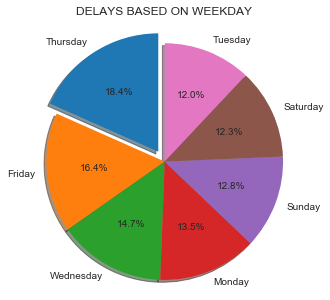

In [22]:

explode = (0.1, 0, 0, 0, 0, 0, 0)

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.set_title('DELAYS BASED ON WEEKDAY')
ax1.pie(week['PERCENTUAL'], explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [23]:
def statistics(df, column_label):
    new_df = df[[column_label,'y']].groupby(column_label).sum()
    new_df['data'] = df[column_label].value_counts().sort_index()
    new_df['PERCENTUAL'] = new_df['y']/new_df['data']*100
    new_df['MEAN'] = sum(new_df['y'])/sum(new_df['data'])*100
    new_df.reset_index(inplace=True)
    return new_df

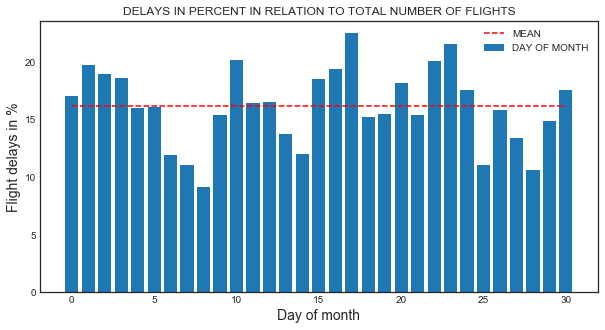

In [24]:
df = statistics(data3, 'DAY_OF_MONTH')

fig2, ax2 = plt.subplots(figsize=(10,5))
ax2.set_title('DELAYS IN PERCENT IN RELATION TO TOTAL NUMBER OF FLIGHTS')
ax2.bar(df.index.values.astype(int), df['PERCENTUAL'], label='DAY OF MONTH')
ax2.plot(df.index.values.astype(int), df['MEAN'], color='r', linestyle='--', label='MEAN')
ax2.set_xlabel('Day of month', fontsize = 14)
ax2.set_ylabel('Flight delays in %', fontsize = 14)
plt.legend()
plt.show()

__When we look at delays in relation to day of month, there isn't a very clear trend. But there is quite a difference between the highest and lowest. But as we only have data from two months we can't conclude much__

    TOTAL_FLIGHTS  PERCENTUAL
9           14357   22.748485
12          48994   22.090460
13          48016   21.042986
8           22576   20.477498
4           40987   19.271964
15          21802   19.067058
6          131271   18.828226
11          46368   18.635697
10          35302   18.208600
16          53395   17.402378
3          150826   16.634400
5           94145   16.348186
7           42776   15.260894
14          32342   14.584750
0          214943   12.297214
2          153331   11.649308
1           13800   11.152174


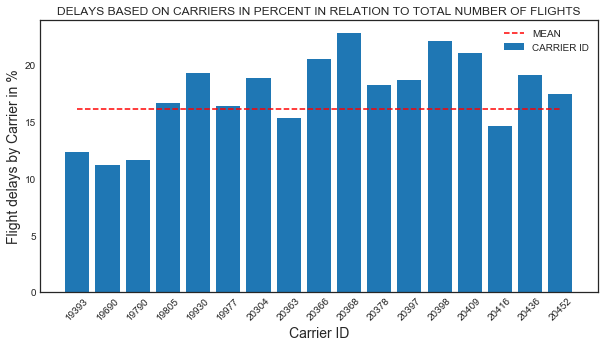

In [25]:
df = statistics(data3, 'OP_CARRIER_AIRLINE_ID')

df.rename(columns={"data": "TOTAL_FLIGHTS"}, inplace=True)
print(df[['TOTAL_FLIGHTS', 'PERCENTUAL']].sort_values(by='PERCENTUAL', ascending=False))
fig1, ax1 = plt.subplots(figsize=(10,5))
ax1.set_title('DELAYS BASED ON CARRIERS IN PERCENT IN RELATION TO TOTAL NUMBER OF FLIGHTS')
plt.bar(np.arange(len(df)), df['PERCENTUAL'], label='CARRIER ID')
ax1.plot(df.index.values.astype(int), df['MEAN'], color='r', linestyle='--', label='MEAN')
ax1.set_xlabel('Carrier ID', fontsize = 14)
ax1.set_ylabel('Flight delays by Carrier in %', fontsize = 14)
plt.xticks(np.arange(len(df)), rotation=45)
ax1.set_xticklabels(df['OP_CARRIER_AIRLINE_ID'])
plt.legend()
plt.show()

__When we look at delays in relation to carrier (company) thers quite a difference between the higeste at almost 23% delays versus the lowest with just about 11% delays.
Even though it's only based on two months of data, each carrier have a lot of flights which makes these calculations more reliable.__

    ORIGIN  TOTAL_FLIGHTS  PERCENTUAL
306    SHR             37   48.648649
233    OGD             17   41.176471
268    PSM             51   37.254902
143    HGR             22   36.363636
18     ASE           1632   35.906863
..     ...            ...         ...
168    ITO           1013    6.021718
259    PIR             56    5.357143
50     BTM            116    5.172414
199    LWS            128    3.125000
78     CPR            173    2.890173

[353 rows x 3 columns]


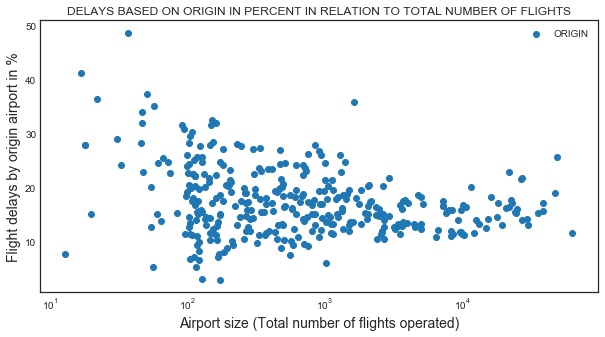

In [26]:
df = statistics(data3, 'ORIGIN')

df.rename(columns={"data": "TOTAL_FLIGHTS"}, inplace=True)
print(df[['ORIGIN', 'TOTAL_FLIGHTS', 'PERCENTUAL']].sort_values(by='PERCENTUAL', ascending=False))
fig1, ax1 = plt.subplots(figsize=(10,5))
ax1.set_title('DELAYS BASED ON ORIGIN IN PERCENT IN RELATION TO TOTAL NUMBER OF FLIGHTS')
plt.scatter(df['TOTAL_FLIGHTS'], df['PERCENTUAL'], label='ORIGIN')
#ax1.plot(df.index.values.astype(int), df['MEAN'], color='r', linestyle='--', label='MEAN')
ax1.set_xlabel('Airport size (Total number of flights operated)', fontsize = 14)
ax1.set_ylabel('Flight delays by origin airport in %', fontsize = 14)
#plt.xticks(np.arange(len(df)), rotation=45)
#ax1.set_xticklabels(df['ORIGIN'])
ax1.set_xscale('log')
plt.legend()
plt.show()

__There is some information we can get from the plot above. The airports with fever flights have a tendency to have more delayed flights leaving.__

    DEST  TOTAL_FLIGHTS  PERCENTUAL
216  MKG             99   35.353535
233  OGD             17   35.294118
18   ASE           1678   34.326579
281  RIW             50   34.000000
235  OGS             59   33.898305
..   ...            ...         ...
21   ATY             56    5.357143
78   CPR            172    5.232558
50   BTM            116    5.172414
339  TWF            177    5.084746
199  LWS            127    4.724409

[353 rows x 3 columns]


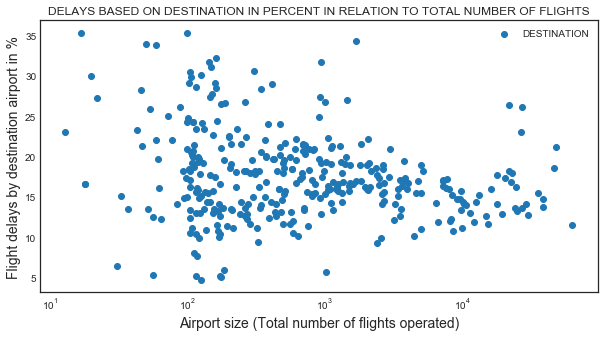

In [27]:
df = statistics(data3, 'DEST')

df.rename(columns={"data": "TOTAL_FLIGHTS"}, inplace=True)
print(df[['DEST', 'TOTAL_FLIGHTS', 'PERCENTUAL']].sort_values(by='PERCENTUAL', ascending=False))
fig1, ax1 = plt.subplots(figsize=(10,5))
ax1.set_title('DELAYS BASED ON DESTINATION IN PERCENT IN RELATION TO TOTAL NUMBER OF FLIGHTS')
plt.scatter(df['TOTAL_FLIGHTS'], df['PERCENTUAL'], label='DESTINATION')
ax1.set_xlabel('Airport size (Total number of flights operated)', fontsize = 14)
ax1.set_ylabel('Flight delays by destination airport in %', fontsize = 14)
ax1.set_xscale('log')
plt.legend()
plt.show()

__Again, There is some information we can get from the plot above. The airports with fever flights have a tendency to have more delayed flights arriving, though the trend is less clear here than with the leaving flights.__

In [42]:
#Split dataset in features and target
def X_y(df):
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    return X_train, X_test, y_train, y_test

In [29]:
data3.dtypes

DAY_OF_MONTH               int64
DAY_OF_WEEK                int64
OP_CARRIER_AIRLINE_ID      int64
OP_CARRIER                object
OP_CARRIER_FL_NUM          int64
ORIGIN_AIRPORT_ID          int64
ORIGIN                    object
DEST_AIRPORT_ID            int64
DEST                      object
DEP_DEL15                float64
DEP_TIME_BLK              object
ARR_TIME                 float64
DISTANCE                 float64
y                          int32
dtype: object

In [37]:
data4 = data3.copy()
data4.iloc[:,2:10] = data3.iloc[:,2:10].astype('category')

In [38]:
def transform(df):
    all_cats = []
    for column in df.iloc[:,2:10].columns:
        all_cats.append(sorted(df[column].unique()))
    
    #We need to encode some of the features as categorical features in either ordinal or one-hot encoding.
    #Get unique values for ordinal encoding
    cat_columns = list(data.iloc[:,2:10].columns.values)
    timeslots = sorted(data.DEP_TIME_BLK.unique().tolist()) #It is important to sort the values, otherwise it isn't ordinal and you will make it a lot harder for the model.
    transformer = make_column_transformer((OrdinalEncoder(categories=[timeslots]), ['DEP_TIME_BLK']), (OneHotEncoder(categories=all_cats), cat_columns), (StandardScaler(), ['DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE']), remainder='passthrough')
    print('Tranform done!')
    return transformer

In [45]:
#Here we calculate metrics for the different algorithms and store the results in a dictionary for later comparison of the results
metrics_dict = dict()

def metrics(grid, X_test, y_test, label):
    global metrics_dict
    
    y_test_scores = grid.predict(X_test)
    lr_probs = grid.predict_proba(X_test)[:,1]
    lr_auc = roc_auc_score(y_test, lr_probs)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
    roc_auc = roc_auc_score(y_test, lr_probs)
    
    
    print(f'BEST PARAMS ARE: {grid.best_params_}')
    print(f'SCORE: {grid.score(X_test, y_test)}')
    print(f'ROC AUC SCORE: {roc_auc_score(y_test, lr_probs):.2f}')
    print(classification_report(y_test, y_test_scores))
    
    print(f'CONFUSION MATRIX: {confusion_matrix(y_test, y_test_scores)}')
    
    #CONFUSION MATRIX PLOT
    plt.style.use('seaborn-white')
    plot_confusion_matrix(grid, X_test, y_test)
    
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    
    
    #ROC AUC CURVE
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    #ax1.set_facecolor('w')
    ax1.plot(lr_fpr, lr_tpr, label=label, linewidth=2)
    # axis labels
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    # show the legend

    metrics_dict = {label: {'precision': lr_precision, 'recall': lr_recall, 'false_positives': lr_fpr, 'true_positives': lr_tpr}}
    
    #PRECISION RECALL PLOT
    #ax2.set_facecolor('w')
    ax2.plot(lr_recall, lr_precision, label='Logistic', linewidth=2)
    # axis labels
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    # show the legend
    plt.legend()
    
    # show the plot
    plt.show()
    return roc_auc, lr_precision, lr_recall

#### Logistic Regression - transform, make pipeline and fit/score data

Tranform done!
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 15.7min
[Parallel(n_jobs=8)]: Done  45 out of  45 | elapsed: 25.2min finished


BEST PARAMS ARE: {'logistic__C': 0.1, 'svd__n_components': 50}
SCORE: 0.9238651430827258
ROC AUC SCORE: 0.88
              precision    recall  f1-score   support

           0       0.95      0.96      0.95    195545
           1       0.78      0.74      0.76     37502

    accuracy                           0.92    233047
   macro avg       0.86      0.85      0.86    233047
weighted avg       0.92      0.92      0.92    233047

CONFUSION MATRIX: [[187506   8039]
 [  9704  27798]]


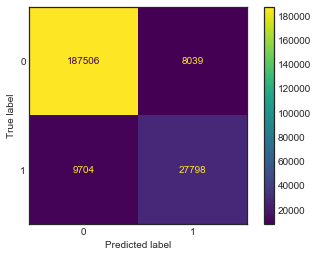

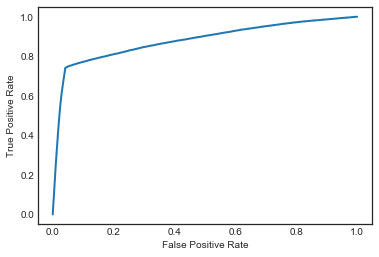

C:\Users\Michael\Anaconda3\envs\keras1\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


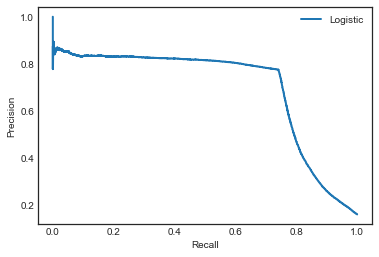

In [46]:
transformer = transform(data4)
X_train, X_test, y_train, y_test = X_y(data4)

svd = TruncatedSVD()
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('transformer', transformer), ('svd', svd), ('logistic', logistic)])
param_grid = {
    'svd__n_components': (50, 300, 50),
    'logistic__C': [.1, 1, .01],
}

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=2, n_jobs=8)
grid.fit(X_train, y_train)

log_roc_auc, log_precision, log_recall = metrics(grid, X_test, y_test, 'LOGISTIC')

#### XGBoost - transform, make pipeline and fit/score data

Tranform done!
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed: 25.6min remaining: 22.4min
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed: 48.2min finished


BEST PARAMS ARE: {'svd__n_components': 150, 'xgb__colsample_bytree': 0.9, 'xgb__gamma': 0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 12, 'xgb__n_estimators': 400, 'xgb__reg_alpha': 0.1, 'xgb__subsample': 0.9}
SCORE: 0.9442472977553884
ROC AUC SCORE: 0.97
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    195545
           1       0.87      0.77      0.82     37502

    accuracy                           0.94    233047
   macro avg       0.91      0.87      0.89    233047
weighted avg       0.94      0.94      0.94    233047

CONFUSION MATRIX: [[191079   4466]
 [  8527  28975]]


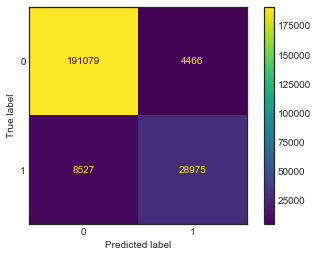

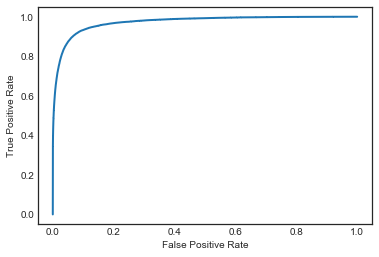

C:\Users\Michael\Anaconda3\envs\keras1\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


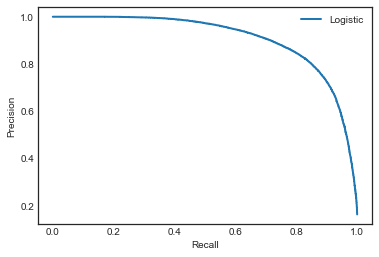

In [48]:
transformer = transform(data4)
X_train, X_test, y_train, y_test = X_y(data4)

svd = TruncatedSVD()
xgb = xgb.XGBClassifier(random_state=42, tree_method='gpu_hist', gpu_id=0, predictor = 'gpu_predictor', sampling_method='gradient_based')
pipe = Pipeline(steps=[('transformer', transformer), ('svd', svd), ('xgb', xgb)])
param_grid = {
    'svd__n_components': [50,100,150],
    'xgb__learning_rate': [0.1],
    'xgb__n_estimators': [400],#range(100,500,100),
    'xgb__max_depth': [12],#range(6,16,2),
    'xgb__gamma': [0],
    'xgb__subsample': [0.9],
    'xgb__colsample_bytree': [0.9],
    'xgb__reg_alpha': [0.1]
}

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=2, n_jobs=8)
grid.fit(X_train, y_train)

xgb_roc_auc, xgb_precision, xgb_recall = metrics(grid, X_test, y_test, 'xgb')

Tranform done!
Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 42.4min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 387.9min
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed: 1505.8min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed: 2992.5min
[Parallel(n_jobs=8)]: Done 960 out of 960 | elapsed: 5499.5min finished


BEST PARAMS ARE: {'rfc__criterion': 'entropy', 'rfc__max_depth': 20, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 300, 'svd__n_components': 50}
SCORE: 0.928962827240857
ROC AUC SCORE: 0.95
              precision    recall  f1-score   support

           0       0.95      0.97      0.96    195545
           1       0.81      0.74      0.77     37502

    accuracy                           0.93    233047
   macro avg       0.88      0.85      0.86    233047
weighted avg       0.93      0.93      0.93    233047

CONFUSION MATRIX: [[188916   6629]
 [  9926  27576]]


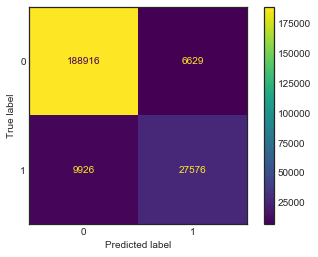

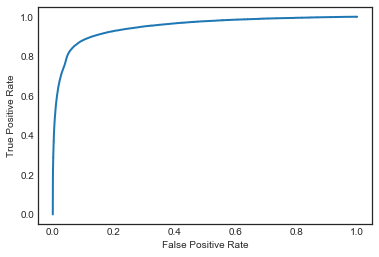

C:\Users\Michael\Anaconda3\envs\keras1\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


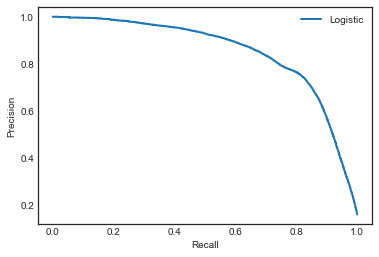

In [52]:
transformer = transform(data4)
X_train, X_test, y_train, y_test = X_y(data4)

svd = TruncatedSVD()
rfc = RandomForestClassifier(random_state=42, n_jobs=8)# , tree_method='gpu_hist', gpu_id=0, predictor = 'gpu_predictor', sampling_method='gradient_based'
pipe = Pipeline(steps=[('transformer', transformer), ('svd', svd), ('rfc', rfc)])
param_grid = {
    'svd__n_components': [50,100,150],
    'rfc__n_estimators': range(100,500,100),
    'rfc__max_depth': range(5,25,5),
    'rfc__criterion': ['gini','entropy'],
    'rfc__min_samples_split': [2,5],
}

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=2, n_jobs=8)
grid.fit(X_train, y_train)

rfc_roc_auc, rfc_precision, rfc_recall = metrics(grid, X_test, y_test, 'rfc')

In [ ]:
fig, ax = plt.subplots(figsize=(20, 30))
xgb.plot_importance(grid, title="Feature importance")

In [ ]:
BEST PARAMS ARE: {'svd__n_components': 150, 'xgb__colsample_bytree': 0.9, 'xgb__gamma': 0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 12, 'xgb__n_estimators': 400, 'xgb__reg_alpha': 0.1, 'xgb__subsample': 0.9}
SCORE: 0.9449510184640867
ROC AUC SCORE: 0.8752480504218072

#### LightGBM

In [ ]:
transformer = transform(data4)
X_train, X_test, y_train, y_test = X_y(data4)

svd = TruncatedSVD()
lgbm = LGBMClassifier(random_state=42, tree_method='gpu_hist', gpu_id=0, predictor = 'gpu_predictor', sampling_method='gradient_based')
pipe = Pipeline(steps=[('transformer', transformer), ('svd', svd), ('lgbm', lgbm)])
param_grid = {
    'svd__n_components': [150],
    'lgbm__learning_rate': [0.1],
    'lgbm__n_estimators': range(50,400,50),
    'lgbm__max_depth': range(6,16,2),
    'lgbm__gamma': [0],
    'lgbm__subsample': [1,0.9],
    'lgbm__colsample_bytree': [0.9],
    'lgbm__reg_alpha': [0.1]
}

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=2, n_jobs=8)
grid.fit(X_train, y_train)

lgbm_roc_auc, lgbm_precision, lgbm_recall = metrics(grid, X_test, y_test, 'LGBM')

#### HistGradientBoostingClassifier

In [ ]:
transformer = transform(data4)
X_train, X_test, y_train, y_test = X_y(data4)

svd = TruncatedSVD()
hist = HistGradientBoostingClassifier(random_state=42)
pipe = Pipeline(steps=[('transformer', transformer), ('svd', svd), ('lgbm', lgbm)])
param_grid = {
    'svd__n_components': [150],
    'lgbm__learning_rate': [0.1, 0.5],
    'lgbm__max_iter': [50,100,150],#range(50,400,50),
    'lgbm__max_depth': range(6,16,2),
    'lgbm__reg_alpha': [0.1]
}

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=2, n_jobs=8)
grid.fit(X_train, y_train)

hgb_roc_auc, hgb_precision, hgb_recall = metrics(grid, X_test, y_test, 'HIST')